Aluno: Igor Tarciano G Silva

Data da criação: 13/09/2025
Ultima atualização: 05/11/2025

Objeitvo:

Projeto com o faco de fazer uma modelo de preditivo que consiga prever os primeiro semestre do ultimo ano, nesse caso 2025.

Fluxo grama:

Apois a criação do banco de dados vendas analise, criamos a tabela Vendas_mes para extrair o valor de venda por mes.

Criamos o modelo a partir da diferenciação da media movel para deixar a variavel alvo estacionaria e utilizamos o SARIMAX para realizar a previsão.  

Com o modelo endogeno criado e previsto, fizemos a escolha de inlcuir uma variavel externa, para deixar o modelo mais robusto e menos pragamatico.

Criamos a tabela Vendas_Registros, onde extraimos a quantidade total vendida, a deixamos estacionaria e também utilizamos o SARIMAX para realizar a previsão.

Dificuldades:

Entendendo que uma alvo pode ter varias variveis que pode ser correlacionada, a problematica maior foi em relacionar o modelo de serie temporal com os dados do banco de dados. No banco de dados tem a tabela dim_tempo, mas não foi possivel relacionar a quantidade que cada produto vendeu por mes (por exemplo), e essa é uma matrica de muito valor quando falamos de estoque e gestão de produtos para analise de vendas.

In [2]:
# Imports para manipulação de dados
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, exc

#Import para tratamento de datas
from datetime import datetime, timedelta

# Imports para visualização de dados
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as m
import seaborn as sns

# Imports para análise e modelagem de séries temporais
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# Importações do scikit-learn
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.exceptions import ConvergenceWarning


# Imports para métricas e performance do modelo
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error
from deap import base, creator, tools, algorithms
import random
from sklearn.neural_network import MLPRegressor

from sklearn.inspection import permutation_importance


# Filtra os warnings
import warnings
warnings.filterwarnings('ignore')




In [3]:
usuario = 'root'
senha = 'root'
host = 'localhost'
port = 3308
bancoorigem = 'vendas_dimensional'
bancodestino = 'vendas_analise'

# Conecta o banco Origem

try:
    engineori = create_engine(f"mysql+pymysql://{usuario}:{senha}@{host}:{port}/{bancoorigem}")
    with engineori.connect() as connori:
        print(f"Conexão com o banco '{bancoorigem}' estabelecida com sucesso.")
except exc.SQLAlchemyError as e:
    print(f"Erro ao conectar ao banco '{bancoorigem}': {e}")
    exit()


#Conecta o banco destino

try:
    enginedes = create_engine(f"mysql+pymysql://{usuario}:{senha}@{host}:{port}/{bancodestino}")
    with enginedes.connect() as conndes:
        print(f"Conexão com o banco '{bancodestino}' estabelecida com sucesso.")
except exc.SQLAlchemyError as e:
    print(f"Erro ao conectar ao banco '{bancodestino}': {e}")
    exit()

# Fazendo a consulta SQL para extrair os dados necessários: variavel endogena

SQL =f"""
select * from Vendas_Registros
"""
Df_vendas_mes = pd.read_sql(SQL, enginedes)
Df_vendas_mes.info()
Df_vendas_mes.describe()

# Fazendo a consulta SQL para extrair os dados necessários: variavel endogena


Conexão com o banco 'vendas_dimensional' estabelecida com sucesso.
Conexão com o banco 'vendas_analise' estabelecida com sucesso.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  73 non-null     int64  
 1   Ano_mes             73 non-null     object 
 2   valor_total_vendas  73 non-null     float64
 3   Preco_Medio_Venda   73 non-null     float64
 4   quantidade_vendida  73 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 3.0+ KB


,id,valor_total_vendas,Preco_Medio_Venda,quantidade_vendida
count,73.000000,7.300000e+01,73.000000,7.300000e+01
mean,37.000000,8.554751e+09,4194.600548,2.040589e+06
std,21.217131,2.921930e+09,41.347097,6.977398e+05
min,1.000000,8.591020e+08,4063.572742,2.048770e+05
25%,19.000000,9.510623e+09,4169.023937,2.281259e+06
50%,37.000000,9.932652e+09,4193.959221,2.350840e+06
75%,55.000000,1.006002e+10,4226.569777,2.398361e+06
max,73.000000,1.030045e+10,4286.354481,2.460411e+06


In [4]:
# Transformando a coluna Ano_mes em datatime onde ela se transformará no índice do DataFrame;

Df_vendas_mes["Ano_mes"] = pd.to_datetime(Df_vendas_mes["Ano_mes"], format="%Y-%m")
Df_vendas_mes.set_index("Ano_mes", inplace=True)
Df_vendas_mes.sort_index(inplace=True)
Df_vendas_mes.drop(columns=["id"], inplace=True)
Df_vendas_mes = Df_vendas_mes.loc["2020-01-01":"2024-12-01"]
Df_vendas_mes
# Levando em considereção que no ano de 2020 teve um elevação abuprita de vendas;
# Vamos fazer a analise baseada no periodo de 2020 ao fim de 2024;

,valor_total_vendas,Preco_Medio_Venda,quantidade_vendida
Ano_mes,,,
2020-01-01,1.004626e+10,4174.462019,2406601.0
2020-02-01,9.489579e+09,4193.959221,2262678.0
2020-03-01,9.994255e+09,4152.012527,2407087.0
2020-04-01,9.680945e+09,4163.861465,2324992.0
2020-05-01,1.018473e+10,4231.543051,2406860.0
2020-06-01,9.930233e+09,4194.720259,2367317.0
2020-07-01,1.013409e+10,4193.179269,2416803.0
2020-08-01,1.007333e+10,4200.089943,2398361.0
2020-09-01,9.674836e+09,4171.968025,2319010.0


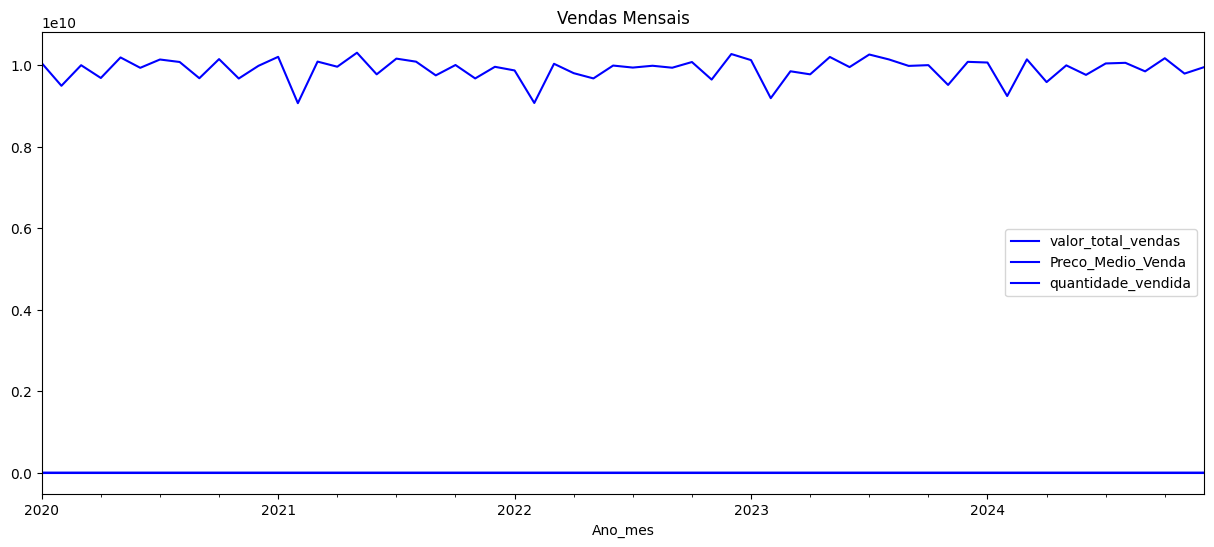

In [5]:
# Plot da serie temporal: primeira analise de tendencia 13
Vendas_analise = Df_vendas_mes.copy()
Vendas_analise.plot(figsize=(15,6), title='Vendas Mensais', color='blue')
plt.show()


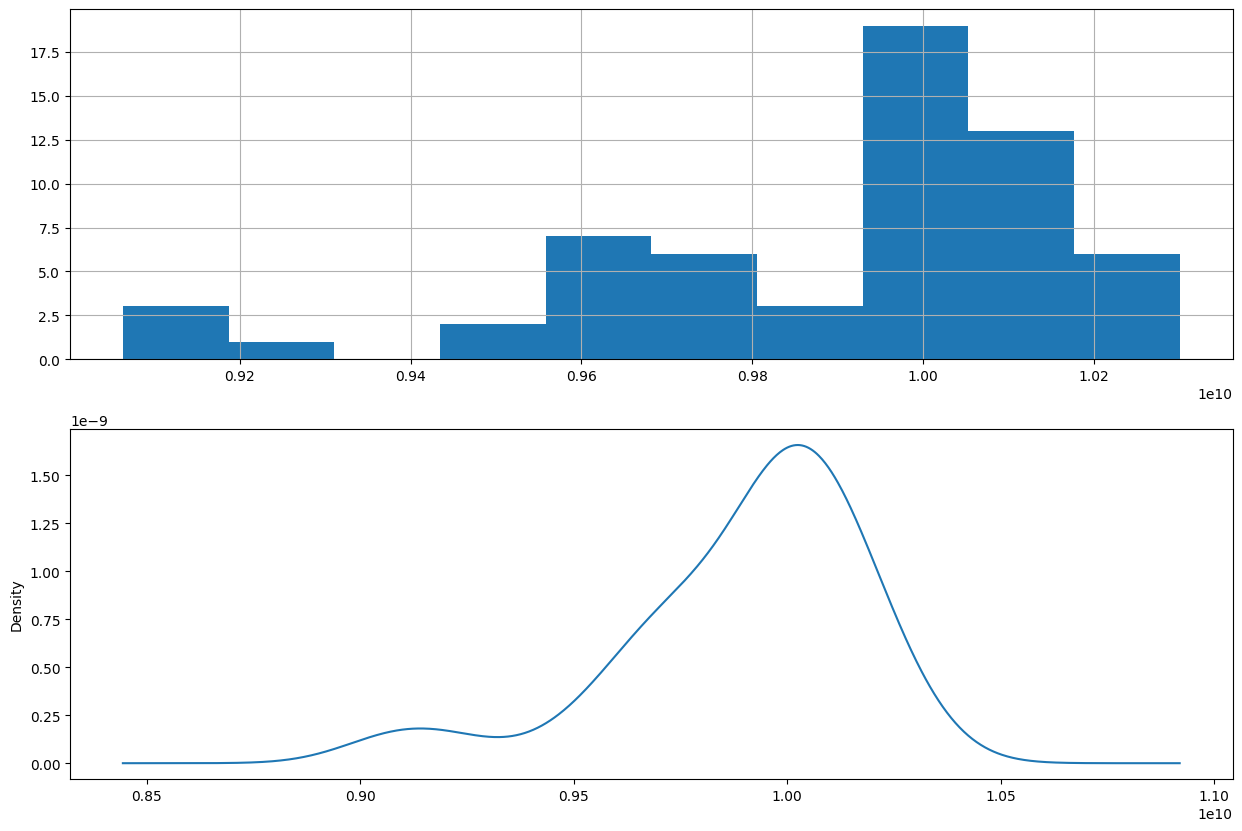

In [6]:
# Grafico de densidade;

plt.figure(figsize=(15,10))
plt.subplot(211)
Vendas_analise.valor_total_vendas.hist()
plt.subplot(212)
Vendas_analise.valor_total_vendas.plot(kind = 'kde')
plt.show()

Text(0, 0.5, '\nValor total de vendas')

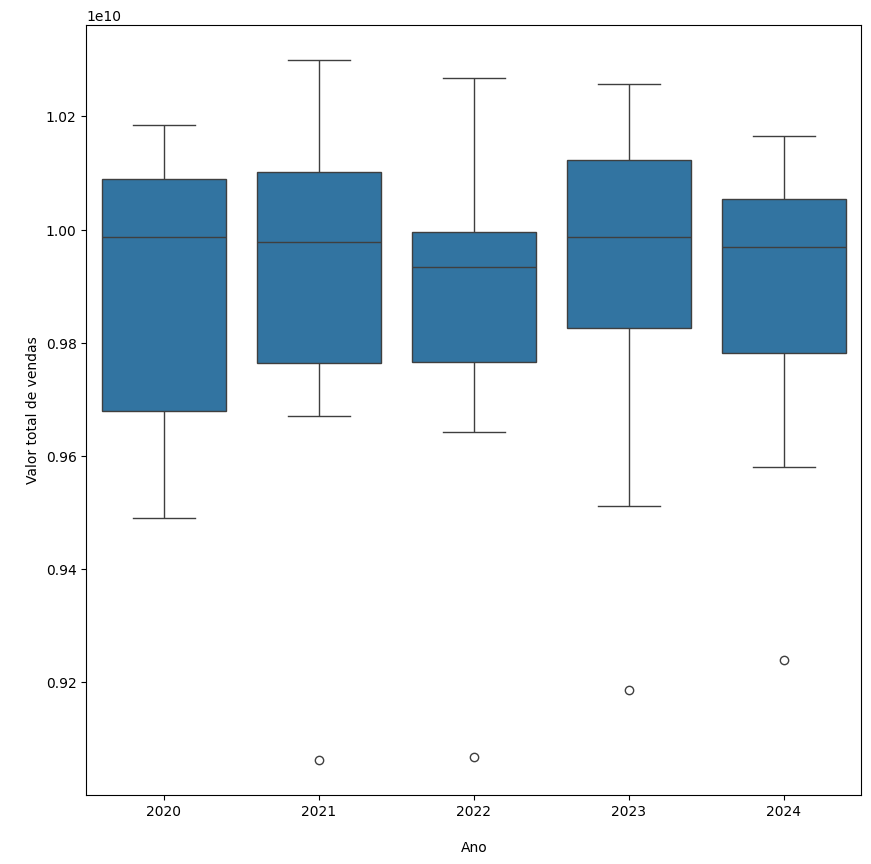

In [7]:
# criando o boxplot para analisar a sazonalidade;

# Define a área de plotagem para os subplots (os boxplots):
fig,ax = plt.subplots(figsize=(10,10))

# definindo as variaveis:
x = Vendas_analise.valor_total_vendas.index.year
y = Vendas_analise.valor_total_vendas

#  Cria um box plot para cada ano usando o Seaborn
# Observe que estamos extraindo o ano (year) do índice da série
sns.boxplot(x = x, y = y, ax = ax, data = Vendas_analise)

plt.xlabel("\nAno")
plt.ylabel("\nValor total de vendas")


Matriz de correlação

Vizualizando a matriz:


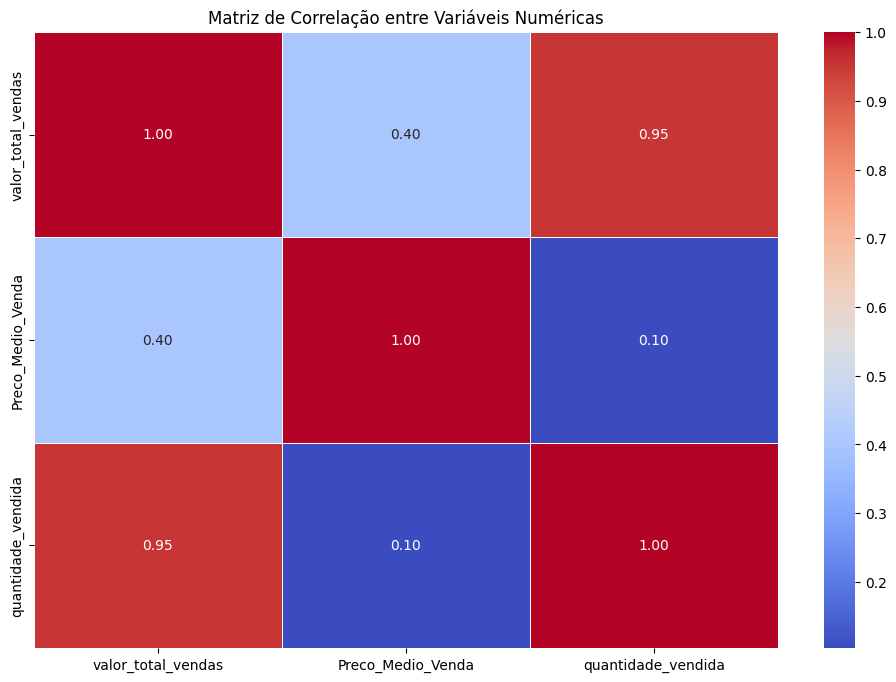

Quantidade vendida é o principal motor do valor total de vendas. Isso faz sentido: vender mais gera mais receita.
Preço médio tem influência, mas não é determinante. Pode indicar que variações no preço não afetam tanto o volume vendido.


In [8]:
# Verifianco a possibilidade de correlação entre as variaveis:

print("\nMatriz de correlação")
Matriz_corr = Vendas_analise.corr()

print("\nVizualizando a matriz:")
plt.figure(figsize=(12,8))
sns.heatmap(Matriz_corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Matriz de Correlação entre Variáveis Numéricas")
plt.show()

print("Quantidade vendida é o principal motor do valor total de vendas. Isso faz sentido: vender mais gera mais receita.")
print("Preço médio tem influência, mas não é determinante. Pode indicar que variações no preço não afetam tanto o volume vendido.")

#  Essas correlações mostram que o estoque não está isolado: ele responde a fatores operacionais (previsão) e afeta resultados (vendas). 



In [9]:
# Criando data frame com as variaveis com mais correlações;
Df_corr = Vendas_analise[['quantidade_vendida','valor_total_vendas']]

In [10]:
'''
Dando os devidos créditos:
Esta função foi recebida no curso de Modelagem de Séries Temporais e Real-Time Analytics
com Apache Spark e Databricks oferecido pela DSA - Data Science Academy
'''

# Função para testar a estacionaridade
def dsa_testa_estacionaridade(serie, window = 30, title = 'Estatísticas Móveis e Teste Dickey-Fuller'):
    """
    Função para testar a estacionaridade de uma série temporal.

    Parâmetros:
    - serie: pandas.Series. Série temporal a ser testada.
    - window: int. Janela para cálculo das estatísticas móveis.
    - title: str. Título para os gráficos.
    """
    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = window).mean()
    rolstd = serie.rolling(window = window).std()

    # Plot das estatísticas móveis
    plt.figure(figsize = (14, 6))
    plt.plot(serie, color = 'blue', label = 'Original')
    plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    plt.plot(rolstd, color = 'black', label = 'Desvio Padrão Móvel')
    plt.legend(loc = 'best')
    plt.title(title)
    plt.show(block = False)

    # Teste Dickey-Fuller
    print('\nResultado do Teste Dickey-Fuller:')
    dfteste = adfuller(serie, autolag = 'AIC')
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)' % key] = value

    print(dfsaida)

    # Conclusão baseada no valor-p
    if dfsaida['Valor-p'] > 0.05:
        print('\nConclusão:\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.\nEssa série provavelmente não é estacionária.')
    else:
        print('\nConclusão:\nO valor-p é menor que 0.05 e, portanto,temos evidências para rejeitar a hipótese nula.\nEssa série provavelmente é estacionária.')

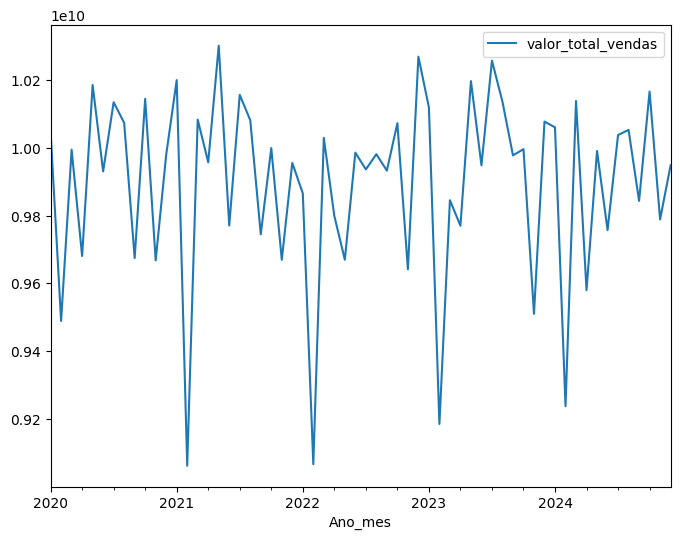

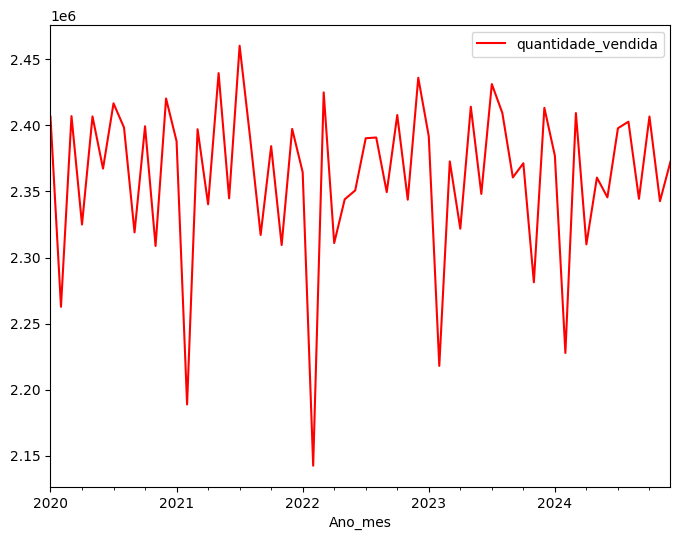

- Faturamento apresenta valores mais altos e mais frequentes, dominando visualmente o gráfico
- Unidades vendidas acompanha a dinâmica do faturamento em vários trechos.


In [11]:
# Separando entre variaveis exogenas e endogenas:

try:
    
    Var_exogena = pd.DataFrame(Df_corr['valor_total_vendas'])
    Var_endogena = pd.DataFrame(Df_corr['quantidade_vendida'])
except Exception as e:
    print("Erro:",e)
    
Var_exogena.plot(figsize=(8,6))
Var_endogena.plot(figsize=(8,6),color='red')
plt.show()

print("- Faturamento apresenta valores mais altos e mais frequentes, dominando visualmente o gráfico")
print('- Unidades vendidas acompanha a dinâmica do faturamento em vários trechos.')


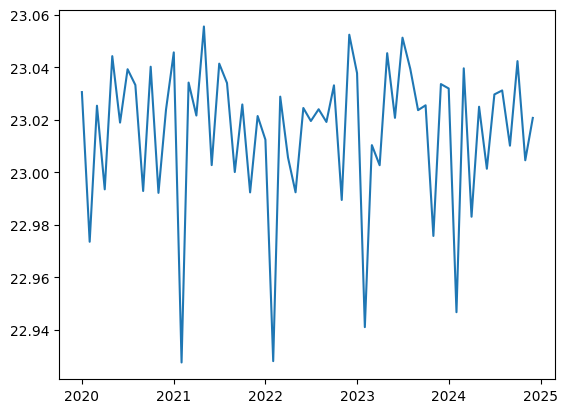

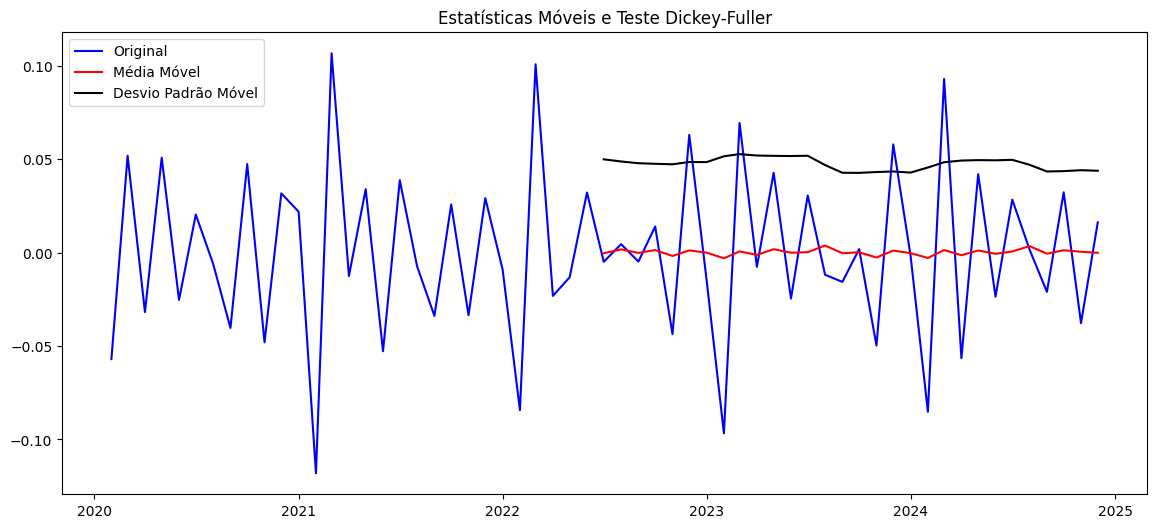


Resultado do Teste Dickey-Fuller:
Estatística do Teste           -7.047835e+00
Valor-p                         5.626437e-10
Número de Lags Consideradas     1.000000e+01
Número de Observações Usadas    4.800000e+01
Valor Crítico (1%)             -3.574589e+00
Valor Crítico (5%)             -2.923954e+00
Valor Crítico (10%)            -2.600039e+00
dtype: float64

Conclusão:
O valor-p é menor que 0.05 e, portanto,temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


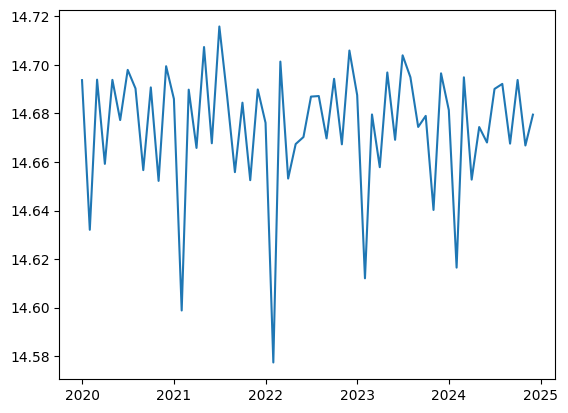

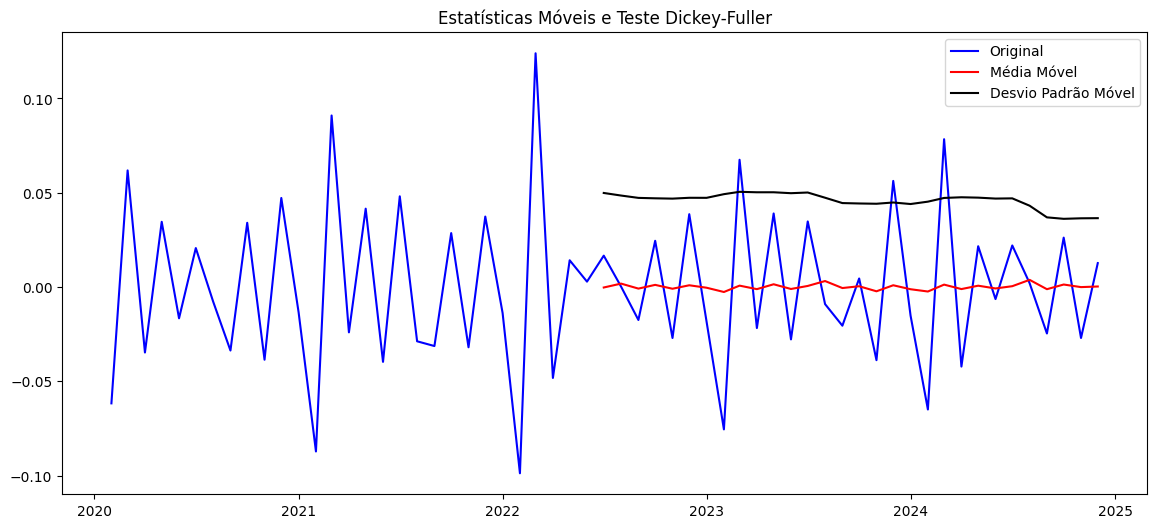


Resultado do Teste Dickey-Fuller:
Estatística do Teste           -8.706844e+00
Valor-p                         3.680569e-14
Número de Lags Consideradas     1.000000e+01
Número de Observações Usadas    4.800000e+01
Valor Crítico (1%)             -3.574589e+00
Valor Crítico (5%)             -2.923954e+00
Valor Crítico (10%)            -2.600039e+00
dtype: float64

Conclusão:
O valor-p é menor que 0.05 e, portanto,temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [12]:
# Tentar deixar estacionaria atraves da retirada da tendencia e sazonalidade;

# --- IGNORE ---
# #  O metodo .diff() para calcular a diferença dos elementos e
# # .dropna() para excluir valores vazios

Dados_series_log = np.log(Var_exogena)
Var_exogena_log = Dados_series_log.diff().dropna()
plt.plot(Dados_series_log)
plt.show()
dsa_testa_estacionaridade(Var_exogena_log)

Dados_series_log = np.log(Var_endogena)
Var_endogena_log = Dados_series_log.diff().dropna()
plt.plot(Dados_series_log)
plt.show()
dsa_testa_estacionaridade(Var_endogena_log)

In [13]:
'''
- O modelo tem variáveis exógenas, sazonalidade, e comportamento complexo
- Podemos encontrar ordens ideais (p,d,q) para SARIMAX, ou melhores configurações de regressoras no Prophet
- Pode testar cenários que seriam difíceis de explorar manualmente
'''
print('Iniciano:')
try:
    X = Var_exogena_log
    y = Var_endogena_log
    
    # Dividiremos em treino e teste;
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    X_train = X_train
    X_test = X_test

    # --- . Configuração do DEAP para o Algoritmo Genético ---

    print('Definindo uma função que receba os parâmetros e retorne uma métrica de desempenho (ex: RMSE, R²):')

    def avaliar_individuo(individuo):
        p, d, q, P, D, Q, s = [int(x) for x in individuo]
        try:
            modelo = SARIMAX(
                y_train,
                exog=X_train,
                order=(p,d,q),
                seasonal_order=(P, D, Q, s),
                enforce_stationarity=False,
                enforce_invertibility=False
                )
            resultado = modelo.fit(disp=False)
            y_pred = resultado.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test)
            rmse = np.sqrt(np.mean((y_test.values.ravel() - y_pred)**2))
            print(f"Testando SARIMAX({p},{d},{q}) x ({P},{D},{Q},{s}) → RMSE: {rmse:.4f}")
        except Exception:
            rmse = 1e6
        return (rmse,)

    print('Configurando o espaço genetico:')
    
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimizar RMSE
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()

    # # Genes: [p, d, q, P, D, Q, s]  # parâmetros SARIMAX
    toolbox.register("p", random.randint, 0, 3)
    toolbox.register("d", random.randint, 0, 2)
    toolbox.register("q", random.randint, 0, 3)
    toolbox.register("P", random.randint, 0, 2)
    toolbox.register("D", random.randint, 0, 1)
    toolbox.register("Q", random.randint, 0, 2)
    toolbox.register("s", random.randint, 4, 12)

    toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.p, toolbox.d, toolbox.q, toolbox.P, toolbox.D, toolbox.Q, toolbox.s), n=1)

    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    
    print('Configurando operador genetico')
    
    toolbox.register("evaluate", avaliar_individuo)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=3)

    print('Executando o algoritmo genetico')
    
    pop = toolbox.population(n=10)
    hof = tools.HallOfFame(1)

    algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, halloffame=hof, verbose=True)

    melhor_individuo = hof[0]
except Exception as e:
    print("Erro:",e)

Iniciano:
Definindo uma função que receba os parâmetros e retorne uma métrica de desempenho (ex: RMSE, R²):
Configurando o espaço genetico:
Configurando operador genetico
Executando o algoritmo genetico
Testando SARIMAX(2,2,0) x (1,1,1,7) → RMSE: 0.0503
Testando SARIMAX(3,1,3) x (0,1,1,6) → RMSE: 0.0439
Testando SARIMAX(3,1,0) x (1,1,0,6) → RMSE: 0.0372
Testando SARIMAX(0,0,3) x (1,0,1,10) → RMSE: 0.0102
Testando SARIMAX(0,1,2) x (0,1,2,11) → RMSE: 0.0265
Testando SARIMAX(0,2,2) x (2,0,0,10) → RMSE: 0.0348
Testando SARIMAX(1,2,2) x (0,1,0,9) → RMSE: 0.0580
Testando SARIMAX(3,0,3) x (0,1,0,5) → RMSE: 0.0224
Testando SARIMAX(3,1,2) x (0,1,0,12) → RMSE: 0.0239
Testando SARIMAX(1,2,0) x (0,0,1,8) → RMSE: 0.0317
gen	nevals
0  	10    
Testando SARIMAX(1,0,3) x (0,1,0,5) → RMSE: 0.0236
Testando SARIMAX(3,1,2) x (0,1,0,10) → RMSE: 0.0325
Testando SARIMAX(0,1,2) x (0,1,1,12) → RMSE: 0.0236
Testando SARIMAX(0,2,2) x (1,0,0,10) → RMSE: 0.0489
Testando SARIMAX(2,2,0) x (1,0,1,6) → RMSE: 0.0153
1  

In [14]:
# Identificando o melhor individuo:

print("Aplicar o modelo final:")
p, d, q, P, D, Q, s = [int(x) for x in melhor_individuo]

modelo_final = SARIMAX(
    y_train,
    exog=y_train,
    order=(p,d,q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
)

resultado_final = modelo_final.fit(disp=False)
y_pred_final = resultado_final.predict(start=len(y_train),end=len(y_train)+len(y_test)-1, exog=X_test)
print(f'{y_pred_final}')

print("Avaliar e visualizar:")

rmse_final = np.sqrt(np.mean((y_test.values.ravel() - y_pred_final)**2))
print(f"RMSE final: {rmse_final:.4f}")


Aplicar o modelo final:
41   -0.057007
42    0.020321
43    0.062936
44    0.106597
45   -0.049759
46    0.028306
47   -0.037759
48    0.100739
49   -0.001679
50   -0.118097
51    0.092879
52    0.050730
53   -0.096731
54   -0.004838
55    0.047334
56    0.038653
57   -0.006013
58   -0.025306
Name: predicted_mean, dtype: float64
Avaliar e visualizar:
RMSE final: 0.0153


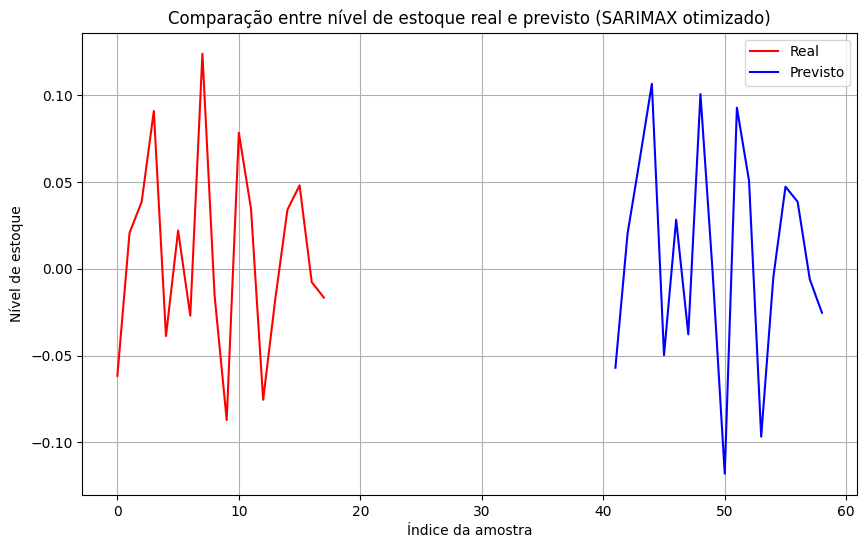

In [15]:
plt.figure(figsize=(10,6))
plt.plot(y_test.values.ravel(), label='Real', color='red')
plt.plot(y_pred_final, label='Previsto', color='blue')
plt.title("Comparação entre nível de estoque real e previsto (SARIMAX otimizado)")
plt.xlabel("Índice da amostra")
plt.ylabel("Nível de estoque")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

# Criar o DataFrame final com valores em log
df_final = pd.DataFrame({
    'Quantidade vendida': y_test.values.ravel(),
    'Quantidade vendida (prevista)': y_pred_final.values.ravel(),
    'Valor total vendas': X_test.values.ravel(),
    'Erro absoluto (log)': np.abs(y_test.values.ravel() - y_pred_final)})

# Reverter log para escala real
df_final['Quantidade vendida'] = np.exp(df_final['Quantidade vendida'])
df_final['Quantidade vendida (prevista)'] = np.exp(df_final['Quantidade vendida (prevista)'])
df_final['Valor total vendas'] = np.exp(df_final['Valor total vendas'])

# Recalcular erro absoluto com valores reais
df_final['Erro absoluto'] = np.abs(df_final['Quantidade vendida'] - df_final['Quantidade vendida (prevista)'])

# Remover a coluna de erro em log (opcional)
df_final.drop(columns=['Erro absoluto (log)'], inplace=True)

# Adicionando a data como coluna
df_final['Data'] = y_test.index
df_final = df_final[['Data', 'Quantidade vendida', 'Quantidade vendida (prevista)', 'Valor total vendas', 'Erro absoluto']]

# Exportar para Excel
df_final.to_excel('resultado_sarimax_com_exogenas.xlsx', index=False)

In [30]:
df_final


,Data,Quantidade vendida,Quantidade vendida (prevista),Valor total vendas,Erro absoluto
41,2020-02-01,0.940197,0.944588,0.944588,0.004391
42,2020-07-01,1.020904,1.020529,1.020529,0.000375
43,2022-12-01,1.039404,1.064959,1.064959,0.025555
44,2021-03-01,1.095259,1.112485,1.112485,0.017226
45,2023-11-01,0.961983,0.951459,0.951459,0.010524
46,2024-07-01,1.022311,1.028711,1.028711,0.006400
47,2024-11-01,0.973356,0.962945,0.962945,0.010411
48,2022-03-01,1.131992,1.105988,1.105988,0.026004
49,2024-01-01,0.984978,0.998322,0.998322,0.013344
50,2021-02-01,0.916514,0.888610,0.888610,0.027904
